# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

class AlbumentationsTransforms:
    def __init__(self, mean, std):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=7, p=0.5),
            A.CoarseDropout(
                max_holes=1, max_height=16, max_width=16,
                min_holes=1, min_height=16, min_width=16,
                fill_value=mean,
                mask_fill_value=None,
                p=0.5
            ),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, image):
        image = np.array(image)
        return self.aug(image=image)["image"]

In [ ]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_transforms = AlbumentationsTransforms(mean=mean, std=std)

test_transforms = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

class TestTransformWrapper:
    def __init__(self, aug):
        self.aug = aug

    def __call__(self, img):
        img = np.array(img)
        return self.aug(image=img)["image"]

# Load datasets
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=TestTransformWrapper(test_transforms))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3076466830.py:10: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
100%|██████████| 170M/170M [00:06<00:00, 26.0MB/s]


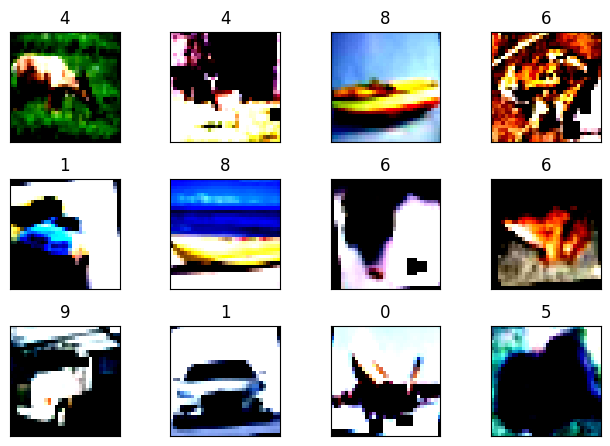

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  # CIFAR images are 3 channels, need to transpose for matplotlib
  plt.imshow(np.transpose(batch_data[i].numpy(), (1, 2, 0)))
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# ------------------------------
# Model Definition
# ------------------------------
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1 (C1) — RF: 3 → 9
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=0, bias=False),   # 32x32x3 → 30x30x32, RF=3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),

            nn.Conv2d(32, 64, kernel_size=3, padding=0, bias=False),  # 30x30x32 → 28x28x64, RF=5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, dilation=2, bias=False),  # 28x28x64 → 24x24x64, RF=9
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False),  # 24x24x64 → 24x24x32
        )

        # CONVOLUTION BLOCK 2 (C2) — RF: 11 → 17
        self.c2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32, bias=False),  # Depthwise → 24x24x32, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=1, padding=0, bias=False),  # Pointwise → 24x24x64, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=False),  # 24x24x64 → 22x22x64, RF=13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, stride=2, bias=False),  # 22x22x64 → 10x10x64, RF=17
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
        )

        # CONVOLUTION BLOCK 3 (C3) — RF: 21 → 29
        self.c3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False),  # 10x10x64 → 10x10x32, RF=17
            nn.AvgPool2d(2, 2),                                       # 10x10x32 → 5x5x32, RF=21

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),  # 5x5x32 → 5x5x64, RF=25
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),  # 5x5x64 → 5x5x64, RF=29
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
        )

        # CONVOLUTION BLOCK 4 (C4) — RF: 44
        self.c4 = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)  # 5x5x64 → 1x1x64, RF=44 (covers full input)
        )

        # OUTPUT BLOCK
        self.output = nn.Sequential(
            nn.Conv2d(64, 10, kernel_size=1, padding=0, bias=False)  # 1x1x64 → 1x1x10
        )

    def forward(self, x):
        x = self.c1(x)       # → 24x24x32
        x = self.c2(x)       # → 10x10x64
        x = self.c3(x)       # → 5x5 → 1x1x64
        x = self.c4(x)       # → 1x1x64
        x = self.output(x)   # → 1x1x10
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

import torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 28, 28]          18,432
              ReLU-6           [-1, 64, 28, 28]               0
       BatchNorm2d-7           [-1, 64, 28, 28]             128
           Dropout-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 24, 24]          36,864
             ReLU-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
          Dropout-12           [-1, 64, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]           2,048
           Conv2d-14           [-1

In [ ]:

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

# ------------------------------
# Training & Testing
# ------------------------------
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return acc

# ------------------------------
# Run Training
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=30
)

EPOCHS = 30
for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    acc = test(model, device, test_loader)


Epoch 1 Loss=1.2894 Acc=41.61: 100%|██████████| 391/391 [00:35<00:00, 10.88it/s]



Test set: Average loss: 1.2453, Accuracy: 5507/10000 (55.07%)



Epoch 2 Loss=1.1974 Acc=57.29: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]



Test set: Average loss: 1.0588, Accuracy: 6184/10000 (61.84%)



Epoch 3 Loss=1.2359 Acc=63.20: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.9969, Accuracy: 6522/10000 (65.22%)



Epoch 4 Loss=1.1301 Acc=67.32: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.8256, Accuracy: 7113/10000 (71.13%)



Epoch 5 Loss=0.9605 Acc=70.21: 100%|██████████| 391/391 [00:37<00:00, 10.30it/s]



Test set: Average loss: 0.7894, Accuracy: 7240/10000 (72.40%)



Epoch 6 Loss=0.6668 Acc=72.46: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 0.7311, Accuracy: 7437/10000 (74.37%)



Epoch 7 Loss=0.7755 Acc=73.89: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s]



Test set: Average loss: 0.6951, Accuracy: 7624/10000 (76.24%)



Epoch 8 Loss=0.5864 Acc=75.85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]



Test set: Average loss: 0.6362, Accuracy: 7767/10000 (77.67%)



Epoch 9 Loss=0.5895 Acc=76.79: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 0.6237, Accuracy: 7857/10000 (78.57%)



Epoch 10 Loss=0.4804 Acc=78.26: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]



Test set: Average loss: 0.5944, Accuracy: 7927/10000 (79.27%)



Epoch 11 Loss=0.7880 Acc=78.86: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s]



Test set: Average loss: 0.5817, Accuracy: 7990/10000 (79.90%)



Epoch 12 Loss=0.5641 Acc=79.84: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.5676, Accuracy: 8056/10000 (80.56%)



Epoch 13 Loss=0.5475 Acc=80.45: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 0.5388, Accuracy: 8188/10000 (81.88%)



Epoch 14 Loss=0.4938 Acc=81.16: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]



Test set: Average loss: 0.5317, Accuracy: 8172/10000 (81.72%)



Epoch 15 Loss=0.3596 Acc=81.51: 100%|██████████| 391/391 [00:37<00:00, 10.31it/s]



Test set: Average loss: 0.5274, Accuracy: 8165/10000 (81.65%)



Epoch 16 Loss=0.3903 Acc=82.47: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Test set: Average loss: 0.4904, Accuracy: 8313/10000 (83.13%)



Epoch 17 Loss=0.4814 Acc=82.73: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]



Test set: Average loss: 0.4875, Accuracy: 8296/10000 (82.96%)



Epoch 18 Loss=0.5352 Acc=83.27: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 0.5051, Accuracy: 8303/10000 (83.03%)



Epoch 19 Loss=0.4681 Acc=83.84: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.4723, Accuracy: 8394/10000 (83.94%)



Epoch 20 Loss=0.3308 Acc=84.31: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.4732, Accuracy: 8398/10000 (83.98%)



Epoch 21 Loss=0.6557 Acc=84.89: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.4662, Accuracy: 8414/10000 (84.14%)



Epoch 22 Loss=0.3532 Acc=85.34: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.4514, Accuracy: 8487/10000 (84.87%)



Epoch 23 Loss=0.3095 Acc=85.71: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]



Test set: Average loss: 0.4381, Accuracy: 8479/10000 (84.79%)



Epoch 24 Loss=0.3466 Acc=86.58: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.4238, Accuracy: 8558/10000 (85.58%)



Epoch 25 Loss=0.3084 Acc=87.29: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 0.4067, Accuracy: 8608/10000 (86.08%)



Epoch 26 Loss=0.4132 Acc=87.89: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 0.4061, Accuracy: 8634/10000 (86.34%)



Epoch 27 Loss=0.3834 Acc=88.27: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]



Test set: Average loss: 0.4006, Accuracy: 8654/10000 (86.54%)



Epoch 28 Loss=0.3412 Acc=88.87: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.3910, Accuracy: 8663/10000 (86.63%)



Epoch 29 Loss=0.2414 Acc=89.15: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.3860, Accuracy: 8695/10000 (86.95%)



Epoch 30 Loss=0.3222 Acc=89.55: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]



Test set: Average loss: 0.3850, Accuracy: 8701/10000 (87.01%)



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# ------------------------------
# Model Definition
# ------------------------------
dropout_value = 0.05

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1 (C1) — RF: 9
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=0, bias=False),  # 32x32 → 30x30, RF=3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),

            nn.Conv2d(32, 64, kernel_size=3, padding=0, bias=False), # 30x30 → 28x28, RF=5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, dilation=2, bias=False), # 28x28 → 24x24, RF=9
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 2 (C2) — RF: 13
        self.c2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False), # 24x24 → 24x24, RF=9
            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32, bias=False),  # Depthwise, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=1, padding=0, bias=False),  # Pointwise, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=False), # 24x24 → 22x22, RF=13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 3 (C3) — RF: 21
        self.c3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=0, stride=2, bias=False), # 22x22 → 10x10, RF=17
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False), # 10x10 → 10x10, RF=17
            nn.AvgPool2d(2, 2)  # 10x10 → 5x5, RF=21
        )

        # CONVOLUTION BLOCK 4 (C4) — RF: 44
        self.c4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),  # 5x5 → 5x5, RF=25
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),  # 5x5 → 5x5, RF=29
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.AvgPool2d(kernel_size=5)  # 5x5 → 1x1, RF=44
        )

        # OUTPUT BLOCK (O) — 1x1x10
        self.output = nn.Conv2d(64, 10, kernel_size=1, padding=0, bias=False)

    def forward(self, x):
        x = self.c1(x)       # → 24x24x64
        x = self.c2(x)       # → 22x22x64
        x = self.c3(x)       # → 5x5x32
        x = self.c4(x)       # → 1x1x64
        x = self.output(x)   # → 1x1x10
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

import torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 28, 28]          18,432
              ReLU-6           [-1, 64, 28, 28]               0
       BatchNorm2d-7           [-1, 64, 28, 28]             128
           Dropout-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 24, 24]          36,864
             ReLU-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
          Dropout-12           [-1, 64, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]           2,048
           Conv2d-14           [-1